# 배틀그라운드 핵 사용 유저 분석 및 ML을 통한 핵 사용 예측

# Table of Content
* 데이터 불러오기 및 클리닝
* EDA
    1. 
    1.

    
  
* 전처리


1. 데이터 분류
2. 연관성 찾기. 입력값과 예측값이 얼마나 연관있는지 파악
3. 넣을 자료 정제. 전처리.
4. 빠진값 넣어주기
5. 스케일링..?
6. 모델 만들기

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# Start Spark Session
spark = SparkSession.builder \
    .master('local[4]') \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "4") \
    .config("spark.cores.max", "4") \
    .appName('pubg_data') \
    .getOrCreate()
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

# Readme 에 PUBG 그래픽 넣고 설명 좀 달고 시작하는거 잊지말자

## 데이터 불러오기 및 클리닝

핵 사용 유저 아이디 3222개는 https://pubg.game.daum.net 에서 가져왔으며,  
2020년 2월1일부터 29일까지 핵 사용으로 인해 정지당한 계정입니다.  
보통 유저 아이디 3533개는 https://www.kaggle.com/leonardokarl/pubg-statisctic 에서 가져왔습니다.  
이후 위 소스에서 가져온 아이디의 게임정보를 https://pubg.op.gg 에서 스크레이핑 했습니다.

자세한 사항은 다음 리포를 참고해 주세요:
https://github.com/alpacapetter/pubg-cheater-behavior-analysis/blob/main/user_data_scraper.py

In [79]:
# Spark.SQL 사용하여 필요 데이터 추출
df_normal = spark.sql(
                        "SELECT *\
                        FROM parquet.`./normal_user_data.parquet`\
                        WHERE type = 'official'\
                        AND (mode = 'tpp' OR mode = 'fpp')"
                        )
df_cheater = spark.sql(
                        "SELECT *\
                        FROM parquet.`./cheater_data.parquet`\
                        WHERE started_at < '2020-03-01'\
                            AND started_at >'2017-12-20'\
                            AND type = 'official'\
                            AND (mode = 'tpp' OR mode = 'fpp')"
                        )

# 간단히 데이터 확인을 위해 Spark DataFrame을 Pandas로 변환
df_normal = df_normal.toPandas()
df_cheater = df_cheater.toPandas()

### 위 SQL 쿼리는 다음과 같은 requirement 에 의해 만들어졌습니다:
1. started_at 이 2020-03-01 이전 데이터만 사용  
    * 2020년 2월에 정지 당했던 유저 데이터중 1년 후 정지가 풀린 후의 게임을 배제합니다.
1. type 이 official인것만 사용  
    * type 이 event인 데스매치의 경우 kill수가 배틀로얄과 다르기 때문에 배제합니다.
1. mode 중 fpp와 tpp만 사용  
    * 282 row의 empty mode 를 배제합니다. 

새로운 column "class"을 만들어서 mapping: cheater=1, normal=0 해준다음 df을 합쳐줍니다.

In [104]:
df_cheater['class'] = 1
df_normal['class'] = 0
df = pd.concat([df_cheater, df_normal])

## 데이터 정제

데이터를 스크레이핑할때부터 이미 스키마를 정한 후 parquet 파일로 저장해줬습니다.

In [75]:
df_cheater.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219690 entries, 0 to 219689
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   type            219690 non-null  object        
 1   mode            219690 non-null  object        
 2   started_at      219690 non-null  datetime64[ns]
 3   total_rank      219690 non-null  int32         
 4   queue_size      219690 non-null  int32         
 5   map_name        210501 non-null  object        
 6   match_type      0 non-null       object        
 7   rank            219690 non-null  int32         
 8   heals           219690 non-null  int32         
 9   boosts          219690 non-null  int32         
 10  death_type      219690 non-null  object        
 11  time_survived   219690 non-null  int32         
 12  kills           219690 non-null  int32         
 13  assists         219690 non-null  int32         
 14  kill_steaks     219690 non-null  int

데이터를 확인합니다.

In [105]:
df.head()

,type,mode,started_at,total_rank,queue_size,map_name,match_type,rank,heals,boosts,...,kills,assists,kill_steaks,headshot_kills,longest_kill,damage_dealt,knock_downs,revives,nickname,class
0,official,tpp,2020-02-22 03:11:00,27,4,Savage_Main,None,27,0,0,...,0,0,0,0,0,0,0,0,jjunbang,1
1,official,tpp,2020-02-22 02:49:52,29,4,Baltic_Main,None,2,10,5,...,16,2,3,5,369,1624,12,1,jjunbang,1
2,official,tpp,2020-02-22 02:35:05,29,4,Savage_Main,None,1,3,6,...,12,0,2,4,154,1933,14,0,jjunbang,1
3,official,tpp,2020-02-22 02:33:14,33,4,Baltic_Main,None,18,6,4,...,8,0,2,1,28,833,6,0,jjunbang,1
4,official,tpp,2020-02-22 02:28:59,29,4,Savage_Main,None,25,1,0,...,1,0,1,0,2,154,1,0,jjunbang,1


스키마를 확인합니다.  
데이터를 스크레이핑할때부터 이미 스키마를 정한 후 parquet 파일로 저장해줬습니다.

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456250 entries, 0 to 236559
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   type            456250 non-null  object        
 1   mode            456250 non-null  object        
 2   started_at      456250 non-null  datetime64[ns]
 3   total_rank      456250 non-null  int32         
 4   queue_size      456250 non-null  int32         
 5   map_name        402222 non-null  object        
 6   match_type      59121 non-null   object        
 7   rank            456250 non-null  int32         
 8   heals           456250 non-null  int32         
 9   boosts          456250 non-null  int32         
 10  death_type      456250 non-null  object        
 11  time_survived   456250 non-null  int32         
 12  kills           456250 non-null  int32         
 13  assists         456250 non-null  int32         
 14  kill_steaks     456250 non-null  int

PANDAS 로 바꾼 후 해야할 일
1. map_name 중 정지 유저에게는 없는 신맵 3개 배제
    * 2020년2월엔 없던 신맵으로 플레이한 row 6117개를 삭제합니다.
1. rank, total rank 묶어서 percentile로 하는게 더 좋겠다.
    * percentile = rank/total_rank
1. mapping: tpp=1, fpp=0
1. mapping: queue_size=3
    * 클래스가 1, 2, 4 밖에 없는데 consistancy를 위해 4를 3으로
1. 필요없는 column 없애기 - type, match_type


전처리
1. Cheater - 최소 banned 되기 전까지 4일간 데이터가 있어야함 만약에 없다면 없는 row는 평균값을 정해서 넣어주기
    * nickname당 started_at 이 같은 row는 average 함 (하루당 row 하나 되도록)

1. 최근 4일간 x=started at, y=kills, groupby nickname 으로 histogram 겹치게 그리기.
    * None value 인것들 찾아서 평균값 혹은 표준편차에서 랜덤값 주기

새로운 column "class"을 만들어서 mapping: cheater=1, normal=0 해준다음 df을 합쳐줍니다.


In [113]:
# 맵 분포도 확인하고 랜덤밸류 넣어주기.
'''사녹 65명
비켄디 99명
파라모 65명
카라킨 65명
헤이븐 30명'''

'사녹 65명\n비켄디 99명\n파라모 65명\n카라킨 65명\n헤이븐 30명'

In [109]:
def bar_chart(col):
    cheater = df[df['class']==1][col].value_counts()
    normal = df[df['class']==0][col].value_counts()
    df_chart = pd.DataFrame([cheater,normal])
    df_chart.index = ['Cheater','Normal']
    df_chart.plot(kind='bar',stacked=True, figsize=(10,5))

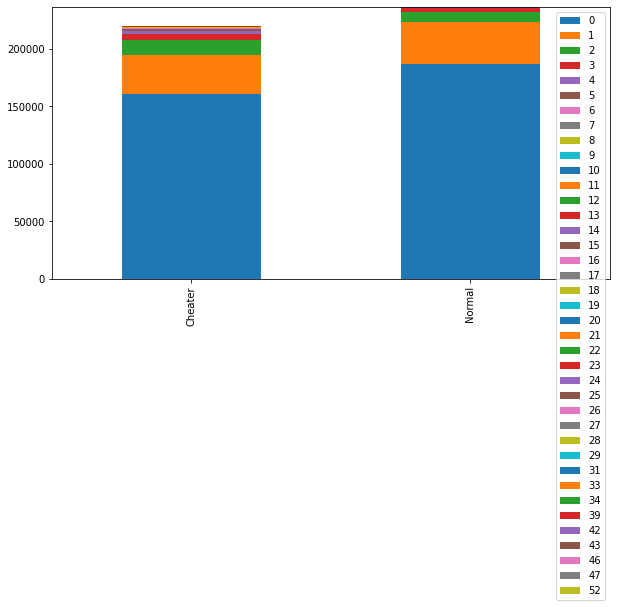

In [112]:
bar_chart('headshot_kills')

In [114]:
df.nunique()

type                   1
mode                   2
started_at        400397
total_rank           101
queue_size             3
map_name               9
match_type             3
rank                 100
heals                 52
boosts                26
death_type             5
time_survived       2108
kills                 52
assists               11
kill_steaks           16
headshot_kills        39
longest_kill         747
damage_dealt        2619
knock_downs           40
revives               14
nickname            6755
class                  2
dtype: int64

In [115]:
df.groupby(['map_name'], as_index=False).count()

,map_name,type,mode,started_at,total_rank,queue_size,match_type,rank,heals,boosts,...,kills,assists,kill_steaks,headshot_kills,longest_kill,damage_dealt,knock_downs,revives,nickname,class
0,Baltic_Main,59927,59927,59927,59927,59927,17007,59927,59927,59927,...,59927,59927,59927,59927,59927,59927,59927,59927,59927,59927
1,Chimera_Main,4551,4551,4551,4551,4551,4551,4551,4551,4551,...,4551,4551,4551,4551,4551,4551,4551,4551,4551,4551
2,Desert_Main,37198,37198,37198,37198,37198,10679,37198,37198,37198,...,37198,37198,37198,37198,37198,37198,37198,37198,37198,37198
3,DihorOtok_Main,26395,26395,26395,26395,26395,7977,26395,26395,26395,...,26395,26395,26395,26395,26395,26395,26395,26395,26395,26395
4,Erangel_Main,27138,27138,27138,27138,27138,0,27138,27138,27138,...,27138,27138,27138,27138,27138,27138,27138,27138,27138,27138
5,Heaven_Main,1418,1418,1418,1418,1418,1418,1418,1418,1418,...,1418,1418,1418,1418,1418,1418,1418,1418,1418,1418
6,Range_Main,148,148,148,148,148,148,148,148,148,...,148,148,148,148,148,148,148,148,148,148
7,Savage_Main,192510,192510,192510,192510,192510,12002,192510,192510,192510,...,192510,192510,192510,192510,192510,192510,192510,192510,192510,192510
8,Summerland_Main,52937,52937,52937,52937,52937,5339,52937,52937,52937,...,52937,52937,52937,52937,52937,52937,52937,52937,52937,52937


In [69]:
1418+148+4551

6117

In [48]:
df_normal.isnull().sum()

type                   0
mode                   0
started_at             0
total_rank             0
queue_size           282
map_name           44839
match_type        177439
rank                   0
heals                  0
boosts                 0
death_type             0
time_survived          0
kills                  0
assists                0
kill_steaks            0
headshot_kills         0
longest_kill           0
damage_dealt           0
knock_downs            0
revives                0
nickname               0
dtype: int64

In [33]:
df_normal.groupby(['mode']).count()

,type,started_at,total_rank,queue_size,map_name,match_type,rank,heals,boosts,death_type,time_survived,kills,assists,kill_steaks,headshot_kills,longest_kill,damage_dealt,knock_downs,revives,nickname
mode,,,,,,,,,,,,,,,,,,,,
fpp,99161,99161,99161,99161,74293,0,99161,99161,99161,99161,99161,99161,99161,99161,99161,99161,99161,99161,99161,99161
tpp,71394,71394,71394,71394,51423,0,71394,71394,71394,71394,71394,71394,71394,71394,71394,71394,71394,71394,71394,71394


In [10]:
df['mode'].unique()

array(['tpp', 'warmodetpp', 'flareguntpp', 'flaregun', '20180324_rifle',
       'crossbowtpp', 'fpp', 'tequilatpp'], dtype=object)

In [ ]:
# df 만들어서 toPandas() 사용하여 visualization 시작
# 예) hi = df_cheater.describe().toPandas()

<br>

In [5]:
# Import user data to PANDAS df
pd_df_cheater = pd.read_parquet("./cheater_data.parquet")
pd_df_normal = pd.read_parquet("./normal_user_data.parquet")

In [6]:
# Import user data to SPARK df
df_cheater = spark.read.parquet("./cheater_data.parquet")
df_normal = spark.read.parquet("./normal_user_data.parquet")

In [13]:
df_cheater.describe()

,total_rank,queue_size,rank,heals,boosts,time_survived,kills,assists,kill_steaks,headshot_kills,longest_kill,damage_dealt,knock_downs,revives
count,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000,219690.000000
mean,37.554977,3.181879,17.498712,1.604074,2.057062,691.476376,2.090273,0.347344,0.836693,0.529983,47.385684,271.574637,1.538782,0.173558
std,20.255474,1.131193,16.322968,2.836149,2.653513,475.877420,3.337031,0.748140,0.946339,1.354325,81.977022,379.766874,2.526510,0.474252
min,1.000000,1.000000,1.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,2.000000,6.000000,0.000000,0.000000,253.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000
50%,29.000000,4.000000,14.000000,0.000000,1.000000,607.000000,1.000000,0.000000,1.000000,0.000000,6.000000,125.000000,1.000000,0.000000
75%,47.000000,4.000000,24.000000,2.000000,3.000000,1083.000000,3.000000,0.000000,1.000000,1.000000,63.000000,359.000000,2.000000,0.000000
max,100.000000,4.000000,100.000000,56.000000,26.000000,2223.000000,56.000000,9.000000,45.000000,52.000000,4530.000000,5361.000000,40.000000,11.000000


In [21]:
df_normal.describe()

,total_rank,queue_size,rank,heals,boosts,time_survived,kills,assists,kill_steaks,headshot_kills,longest_kill,damage_dealt,knock_downs,revives
count,170555.000000,170555.000000,170555.000000,170555.00000,170555.000000,170555.000000,170555.000000,170555.000000,170555.000000,170555.000000,170555.000000,170555.000000,170555.000000,170555.000000
mean,44.058931,2.900923,21.500941,1.67570,1.385148,740.029973,1.116379,0.288652,0.620926,0.280936,29.564868,159.549248,0.781554,0.169060
std,22.738714,1.196114,18.280119,3.07976,1.991976,546.695951,1.743302,0.660529,0.744925,0.686077,60.494791,196.366062,1.270147,0.472004
min,1.000000,1.000000,1.000000,0.00000,0.000000,-1935.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,2.000000,8.000000,0.00000,0.000000,241.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000
50%,32.000000,4.000000,18.000000,0.00000,0.000000,604.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
75%,49.000000,4.000000,28.000000,2.00000,2.000000,1182.000000,2.000000,0.000000,1.000000,0.000000,30.000000,221.000000,1.000000,0.000000
max,101.000000,4.000000,100.000000,66.00000,21.000000,2204.000000,39.000000,10.000000,15.000000,33.000000,1037.000000,3839.000000,30.000000,12.000000
